<a href="https://colab.research.google.com/github/tianyunh/BIOSTAT823-Project/blob/main/10_Code/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BIOSTAT 823 Final Project - Face Mask Detection

### Clone repository from Github

In [1]:
!git clone https://github.com/tianyunh/BIOSTAT823-Project.git

Cloning into 'BIOSTAT823-Project'...
remote: Enumerating objects: 11684, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 11684 (delta 23), reused 31 (delta 15), pack-reused 11636
Receiving objects: 100% (11684/11684), 329.47 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (11820/11820), done.


In [2]:
import numpy as np
import pandas as pd
import cv2 # opencv
import matplotlib.pyplot as plt
# keras
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
import os
from sklearn.utils import shuffle
import glob
from warnings import filterwarnings
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

### Load data

In [3]:
path  = "/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/"

In [4]:
# function for getting nonhidden files
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [7]:
df = {"image_path":[],"category":[],"set":[]}
for folder in listdir_nohidden(path):
    for f2 in os.listdir(path+"/"+folder):
        for image in glob.glob(path+folder+"/"+f2+"/"+"*.png"):
            df["image_path"].append(image)
            df["category"].append(f2)
            df["set"].append(folder)
df = pd.DataFrame(df)
df.sample(5)

,image_path,category,set
4214,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Train
1185,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Train
11116,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Validation
11021,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithoutMask,Validation
7332,/content/BIOSTAT823-Project/00_Data/Face Mask ...,WithMask,Train


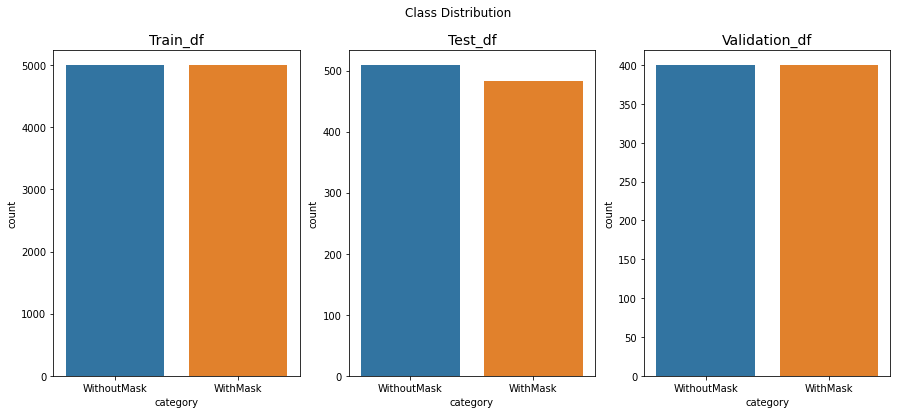

In [10]:
# visualize class distribution
train_df = df[df["set"] == "Train"]
test_df = df[df["set"] == "Test"]
valid_df = df[df["set"] == "Validation"]

plt.figure(figsize = (15,6))
plt.suptitle("Class Distribution")
plt.subplot(1,3,1)
sns.countplot(train_df["category"])
plt.title("Train_df", size = 14)


plt.subplot(1,3,2)
sns.countplot(test_df["category"])
plt.title("Test_df", size = 14)


plt.subplot(1,3,3)
sns.countplot(valid_df["category"])
plt.title("Validation_df", size = 14)

plt.savefig('class_distribution.png')
plt.show()

As shown in the plots above, the classes are quite balanced in the dataset, so we do not need further preprocessing for class distribution.

In [11]:
# Read data
train_dir = '/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/Train'
test_dir = '/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/Test'
val_dir = '/content/BIOSTAT823-Project/00_Data/Face Mask Dataset/Validation'

Found 10000 files belonging to 2 classes.


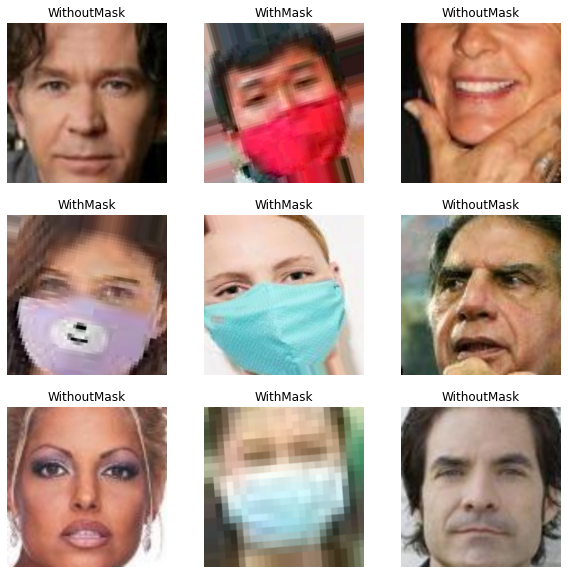

In [18]:
# visualize some sample images from train
train = keras.utils.image_dataset_from_directory(train_dir,
                                                 batch_size=32,
                                                 shuffle=True)
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train.class_names[labels[i]])
    plt.axis("off")

plt.savefig('sample.png')

### Data Augmentation
Data augmentation is a process of artificially increasing the amount of data by generating new data points from existing data. In the field of deep learning and computer vision, data augmentation helps create variability and flexibility in data models, reduce overfitting, and increase the generalization ability of the models. Here we implement data augmentation by making small changes (ex. flip, zoom, shear) to the images in the training set.

In [19]:
# data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32,seed=42,shuffle = False)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32,seed=42,shuffle = False)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32,seed=42,shuffle = False)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


### CNN Models
We will explore and tune different CNN models to find the best fit.

To start with, we first try a customized CNN model with a simple architecture.

**Customized CNN**


In [29]:
# customize CNN
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same',input_shape=(128,128,3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 128)     

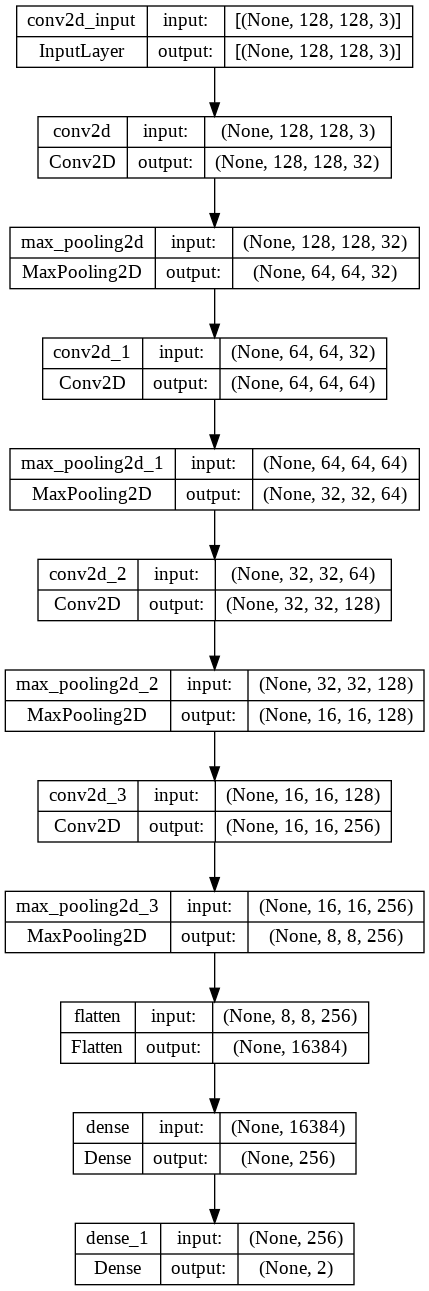

In [26]:
keras.utils.plot_model(model, show_shapes=True, to_file='model1.png')

In [30]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

cnn_history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 47s 148ms/step - loss: 0.6835 - accuracy: 0.7056 - val_loss: 0.2816 - val_accuracy: 0.9025
Epoch 2/30
313/313 [==============================] - 46s 148ms/step - loss: 0.2018 - accuracy: 0.9294 - val_loss: 0.1224 - val_accuracy: 0.9525
Epoch 3/30
313/313 [==============================] - 46s 148ms/step - loss: 0.0937 - accuracy: 0.9679 - val_loss: 0.0408 - val_accuracy: 0.9812
Epoch 4/30
313/313 [==============================] - 47s 151ms/step - loss: 0.0637 - accuracy: 0.9756 - val_loss: 0.0370 - val_accuracy: 0.9862
Epoch 5/30
313/313 [==============================] - 46s 148ms/step - loss: 0.0584 - accuracy: 0.9776 - val_loss: 0.0224 - val_accuracy: 0.9887
Epoch 6/30
313/313 [==============================] - 46s 148ms/step - loss: 0.0451 - accuracy: 0.9837 - val_loss: 0.0318 - val_accuracy: 0.9850
Epoch 7/30
313/313 [==============================] - 46s 148ms/step - loss: 0.0400 - accuracy: 0.9859 - val_loss: 0.0302 - val_ac

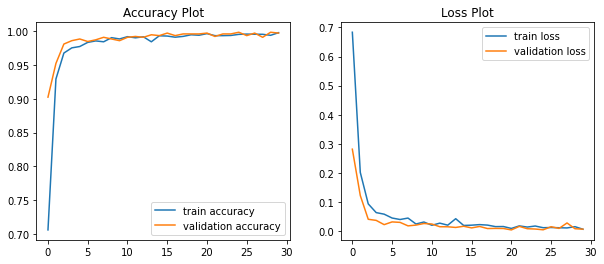

In [31]:
# visualize accuracy/loss

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(cnn_history.history["accuracy"], label = "train accuracy")
plt.plot(cnn_history.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(cnn_history.history["loss"], label = "train loss")
plt.plot(cnn_history.history["val_loss"], label = "validation loss")
plt.title('Loss Plot')
plt.legend()
plt.show()

In [32]:
cnn_acc = model.evaluate(test_generator)
cnn_acc

31/31 [==============================] - 2s 54ms/step - loss: 0.0343 - accuracy: 0.9899


[0.034335166215896606, 0.9899193644523621]

The performance of customized CNN is not bad. However, we can also try utilizing some pre-trained models and transfer learning to see if we can achieve better results.

**VGG 19**

The second architecture we try is VGG19 transfer learning model. We will use VGG19 architecture as a foundation and add a few more layers to tailor the model to the current classification of mask detection.


In [33]:
# vgg19

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [34]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

vgg19_history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 53s 163ms/step - loss: 0.2156 - accuracy: 0.9219 - val_loss: 0.0420 - val_accuracy: 0.9900
Epoch 2/30
313/313 [==============================] - 54s 171ms/step - loss: 0.0649 - accuracy: 0.9773 - val_loss: 0.0549 - val_accuracy: 0.9787
Epoch 3/30
313/313 [==============================] - 50s 159ms/step - loss: 0.0525 - accuracy: 0.9808 - val_loss: 0.0150 - val_accuracy: 0.9962
Epoch 4/30
313/313 [==============================] - 49s 158ms/step - loss: 0.0387 - accuracy: 0.9854 - val_loss: 0.0137 - val_accuracy: 0.9975
Epoch 5/30
313/313 [==============================] - 50s 158ms/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 6/30
313/313 [==============================] - 50s 160ms/step - loss: 0.0277 - accuracy: 0.9902 - val_loss: 0.0265 - val_accuracy: 0.9900
Epoch 7/30
313/313 [==============================] - 50s 159ms/step - loss: 0.0272 - accuracy: 0.9896 - val_loss: 0.0105 - val_ac

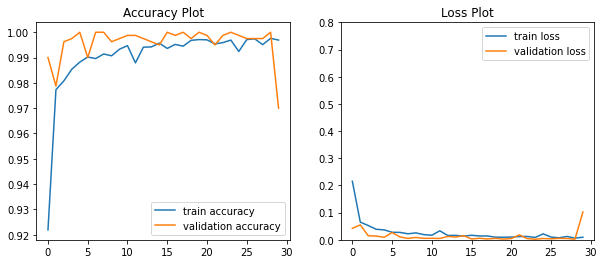

In [35]:
# visualize accuracy/loss
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(vgg19_history.history["accuracy"], label = "train accuracy")
plt.plot(vgg19_history.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(vgg19_history.history["loss"], label = "train loss")
plt.plot(vgg19_history.history["val_loss"], label = "validation loss")
plt.ylim([0, 0.8])
plt.title('Loss Plot')
plt.legend()
plt.show()

In [36]:
vgg_acc = model.evaluate(test_generator)
vgg_acc

31/31 [==============================] - 2s 72ms/step - loss: 0.1554 - accuracy: 0.9748


[0.1554338037967682, 0.9747983813285828]

**Resnet101**

Similarly, we will use Resnet101 transfer learning model as the next architecture.

In [37]:
# resnet
resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(128,128,3))
for layer in resnet101v2.layers:
    layer.trainable = False

# add layers
model = Sequential()
model.add(resnet101v2)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid')) #two classes
model.summary()

171317808/171317808 [==============================] - 8s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 42,692,098
Trainable params: 65,538
Non-trainable params: 42,626,560
_________________________________________________________________


In [38]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

resnet_history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 59s 169ms/step - loss: 0.2871 - accuracy: 0.9807 - val_loss: 0.0058 - val_accuracy: 0.9987
Epoch 2/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0374 - accuracy: 0.9958 - val_loss: 0.0534 - val_accuracy: 0.9962
Epoch 3/30
313/313 [==============================] - 51s 163ms/step - loss: 0.0335 - accuracy: 0.9963 - val_loss: 0.0488 - val_accuracy: 0.9962
Epoch 4/30
313/313 [==============================] - 51s 164ms/step - loss: 0.0452 - accuracy: 0.9965 - val_loss: 8.2876e-05 - val_accuracy: 1.0000
Epoch 5/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0181 - accuracy: 0.9982 - val_loss: 8.0855e-05 - val_accuracy: 1.0000
Epoch 6/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0321 - accuracy: 0.9983 - val_loss: 0.0019 - val_accuracy: 0.9987
Epoch 7/30
313/313 [==============================] - 53s 169ms/step - loss: 0.0129 - accuracy: 0.9993 - val_loss: 4.0434e

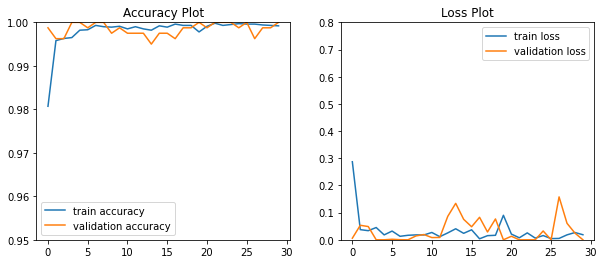

In [39]:
# visualize accuracy/loss
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(resnet_history.history["accuracy"], label = "train accuracy")
plt.plot(resnet_history.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')
plt.ylim([0.95, 1])

plt.subplot(1,2,2)
plt.plot(resnet_history.history["loss"], label = "train loss")
plt.plot(resnet_history.history["val_loss"], label = "validation loss")
plt.ylim([0, 0.8])
plt.title('Loss Plot')
plt.legend()
plt.show()

# validation loss osiliate > overfitting

The above loss plot shows that the validation loss oscillates much while the training loss has gone down, which indicates an overfitting here. Thus, I tried to lower the learning rate to reduce overfitting issue and re-fit the model:

In [40]:
# resnet
resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(128,128,3))
for layer in resnet101v2.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet101v2)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 42,692,098
Trainable params: 65,538
Non-trainable params: 42,626,560
_________________________________________________________________


In [41]:
# lower learning rate
model.compile(optimizer=Adam(0.0005),loss="categorical_crossentropy",metrics ="accuracy")

resnet_history2 = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator)

Epoch 1/30
313/313 [==============================] - 58s 171ms/step - loss: 0.1733 - accuracy: 0.9813 - val_loss: 0.0043 - val_accuracy: 0.9975
Epoch 2/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0245 - accuracy: 0.9956 - val_loss: 0.0183 - val_accuracy: 0.9950
Epoch 3/30
313/313 [==============================] - 51s 164ms/step - loss: 0.0158 - accuracy: 0.9975 - val_loss: 0.0132 - val_accuracy: 0.9962
Epoch 4/30
313/313 [==============================] - 52s 166ms/step - loss: 0.0093 - accuracy: 0.9986 - val_loss: 0.0052 - val_accuracy: 0.9987
Epoch 5/30
313/313 [==============================] - 53s 168ms/step - loss: 0.0169 - accuracy: 0.9976 - val_loss: 4.9204e-04 - val_accuracy: 1.0000
Epoch 6/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 2.4789e-04 - val_accuracy: 1.0000
Epoch 7/30
313/313 [==============================] - 51s 164ms/step - loss: 0.0148 - accuracy: 0.9981 - val_loss: 0.0524 

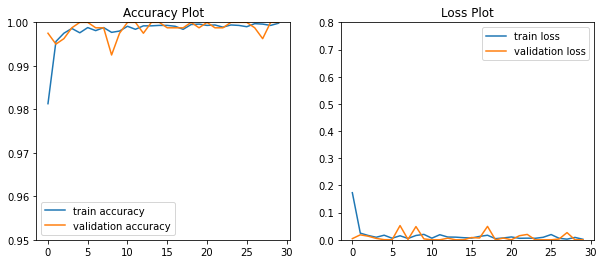

In [42]:
# visualize accuracy/loss
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(resnet_history2.history["accuracy"], label = "train accuracy")
plt.plot(resnet_history2.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.title('Accuracy Plot')
plt.ylim([0.95, 1])

plt.subplot(1,2,2)
plt.plot(resnet_history2.history["loss"], label = "train loss")
plt.plot(resnet_history2.history["val_loss"], label = "validation loss")
plt.ylim([0, 0.8])
plt.title('Loss Plot')
plt.legend()
plt.show()

In [43]:
resnet_acc = model.evaluate(test_generator)
resnet_acc

31/31 [==============================] - 2s 77ms/step - loss: 0.0462 - accuracy: 0.9990


[0.04617244377732277, 0.9989919066429138]

### Compare Models
In this section, we visualize the accuracy/loss plot for all the model architecture we fitted before and compare their performance.

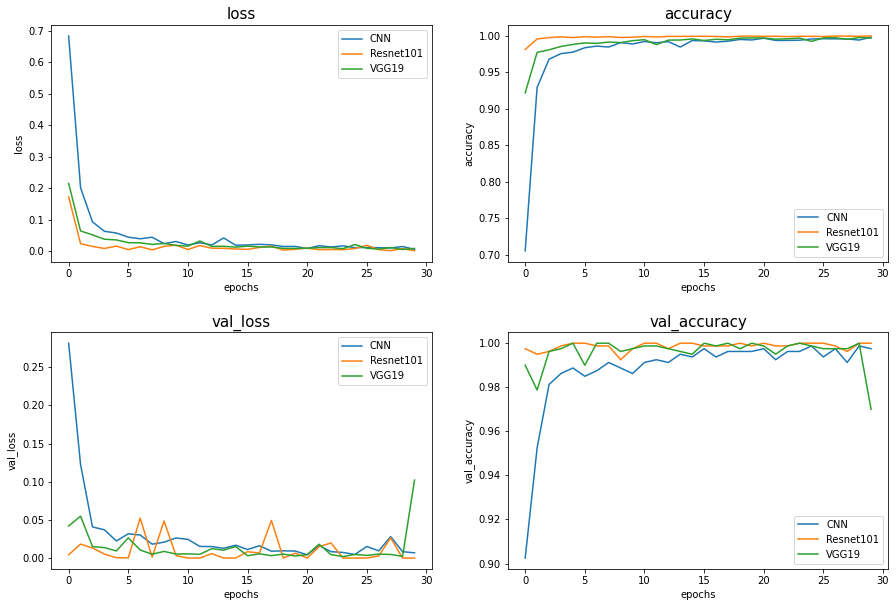

<Figure size 432x288 with 0 Axes>

In [47]:
# get model training history
model_hist = [cnn_history,resnet_history2,vgg19_history]
names = ['CNN','Resnet101','VGG19']

# plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_hist[0].history:
    index = list(model_hist[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_hist:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric, size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()
plt.savefig('model comparison.png')

In [50]:
# compare test accuracy
acc={'Nets':['CNN','VGG-19','ResNet101'],
      'Accuracy':[cnn_acc[1],vgg_acc[1],resnet_acc[1]]}

df = pd.DataFrame(acc)

df.sort_values('Accuracy', ascending=False)

,Nets,Accuracy
2,ResNet101,0.998992
0,CNN,0.989919
1,VGG-19,0.974798


The results above indicate that Resnet102 transfer learning model performs best among all. Therefore, we will re-train the model and apply early stopping to prevent overfitting.

In [62]:
# retrain

resnet101v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=(128,128,3))
for layer in resnet101v2.layers:
    layer.trainable = False

# add layers
model = Sequential()
model.add(resnet101v2)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid')) #two classes

model.compile(optimizer=Adam(0.0005),loss="categorical_crossentropy",metrics ="accuracy")

# Using EarlyStopping, end training when val_accuracy is not improved for 6 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                patience=6,restore_best_weights=True)
# training
history = model.fit(train_generator,batch_size=32,epochs=30,
        validation_data=val_generator,callbacks=[early_stopping])

Epoch 1/30
313/313 [==============================] - 61s 175ms/step - loss: 0.1099 - accuracy: 0.9841 - val_loss: 0.0167 - val_accuracy: 0.9950
Epoch 2/30
313/313 [==============================] - 54s 172ms/step - loss: 0.0291 - accuracy: 0.9958 - val_loss: 0.0015 - val_accuracy: 0.9987
Epoch 3/30
313/313 [==============================] - 52s 166ms/step - loss: 0.0176 - accuracy: 0.9969 - val_loss: 4.1768e-04 - val_accuracy: 1.0000
Epoch 4/30
313/313 [==============================] - 51s 164ms/step - loss: 0.0130 - accuracy: 0.9986 - val_loss: 0.0190 - val_accuracy: 0.9975
Epoch 5/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0108 - accuracy: 0.9991 - val_loss: 0.0076 - val_accuracy: 0.9987
Epoch 6/30
313/313 [==============================] - 53s 168ms/step - loss: 0.0293 - accuracy: 0.9973 - val_loss: 0.0080 - val_accuracy: 0.9987
Epoch 7/30
313/313 [==============================] - 52s 165ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0047 - va

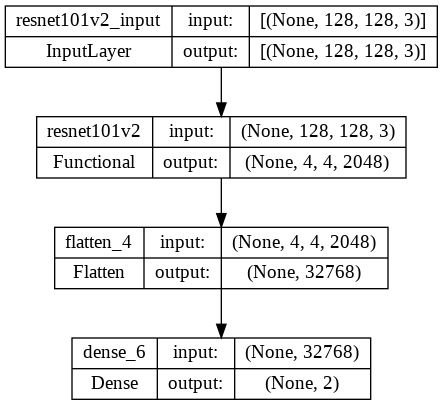

In [61]:
# plot model architecture
keras.utils.plot_model(model, show_shapes=True,to_file='model2.png')

### Model Performance

In [63]:
# evaluate model performance on test set
model.evaluate(test_generator)

31/31 [==============================] - 2s 77ms/step - loss: 0.0346 - accuracy: 0.9970


[0.03455132991075516, 0.9969757795333862]

31/31 [==============================] - 4s 74ms/step


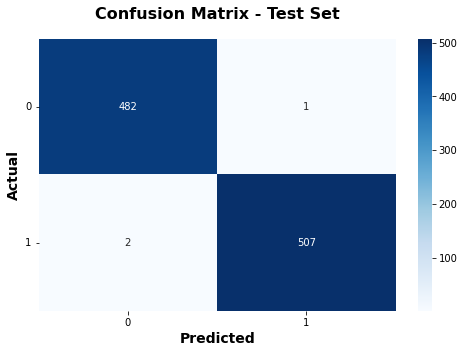

<Figure size 432x288 with 0 Axes>

In [64]:
# Plot confusion matrix
prediction = model.predict(test_generator)
pred_prob = []
for p in prediction:
  pred_prob.append(p[1])

test_pred = np.argmax(prediction,axis = 1)

plt.figure(figsize = (8,5))
ax = sns.heatmap(confusion_matrix(test_generator.labels, test_pred), annot = True,fmt="d",cmap = "Blues")

ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)
plt.show()
plt.savefig('confusion matrix.png')

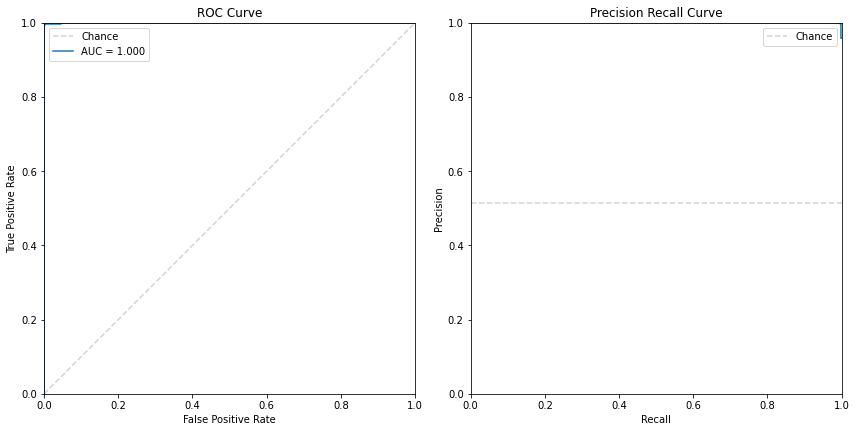

In [65]:
# ROC, Precision-Recall Plot

# calculate fraction of positive examples for future plots
test_label = test_generator.labels
fraction_positive_examples = np.count_nonzero(test_label == 1)/len(test_label)
fraction_positive_examples

from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

# plot ROC curve and precision-recall curve
# initialize each plot
fig, axs = plt.subplots(1,2,figsize=(12,6))

# plot the chance diagonal and PR random chance lines
axs[0].plot((0,1),(0,1),color='lightgrey',linestyle='--', label='Chance')
axs[1].plot((0,1),(fraction_positive_examples, fraction_positive_examples),color='lightgrey',linestyle='--', label='Chance')

# get fpr, tpr, precision, recall, auc for plots
fpr, tpr, _ = roc_curve(test_label, pred_prob)
precision, recall, _ = precision_recall_curve(test_label, pred_prob)
roc_auc = auc(fpr,tpr)

# plot ROC curve
axs[0].plot(fpr, tpr, label='AUC = {:.3f}'.format(roc_auc))
    
# plot the PR curve
axs[1].plot(recall, precision)

for ax in axs:
    ax.axis('square')
    ax.set(xlim=(0,1), ylim=(0,1))
    ax.legend()
axs[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
axs[1].set(xlabel='Recall', ylabel='Precision', title='Precision Recall Curve')
plt.tight_layout()
plt.show()



While overlapped with x and y axis, the ROC curve is framed towards the upper left corner and the precision-recall curve is framed towards the upper right corner, which both indicate good-performing model results.

### Mask Detection
#### Incorporate with haar cascade face detection
To visualize our model prediction in a more real-world setting, we will use a pre-trained Haar Cascade Model for face detection in order to obtain the bounding box coordinates of faces in an image.

In [51]:
# import cascade classifier
face_model = cv2.CascadeClassifier('/content/BIOSTAT823-Project/00_Data/haarcascade/haarcascade_frontalface_default.xml')

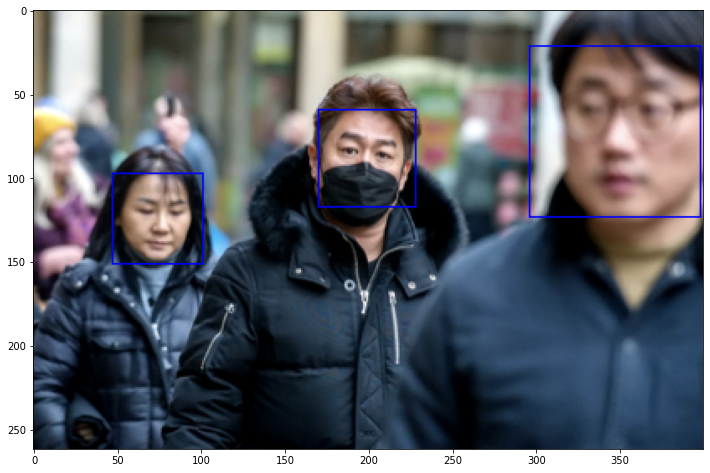

In [55]:
# try it out on a sample image
img = cv2.imread('/content/BIOSTAT823-Project/00_Data/Predict Sample/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) 

# color the image
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 

# plot bounding boxes for faces
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

Next, we integrate this face detection model with our CNN model to further visualize the prediction results. The green bounding box indicates that the face mask is detected while the red bounding box shows no face mask is detected.

In [57]:
mask_label = {0:'MASK',1:'NO MASK'}
color_label = {0:(0,255,0),1:(255,0,0)} # rectangle color

def plot_image(image,subplot):
    plt.subplot(*subplot)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show

def detect_mask(image_dir):
    img = cv2.imread(image_dir)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    
    #returns a list of (x,y,w,h) tuples
    faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
    
    out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    plt.figure(figsize=(20,20))
    plot_image(out_img,(1,2,1))

    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = out_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop).argmax()
        cv2.rectangle(out_img,(x,y),(x+w,y+h),color_label[mask_result],1)
    
    plot_image(out_img,(1,2,2))

1/1 [==============================] - 0s 26ms/step


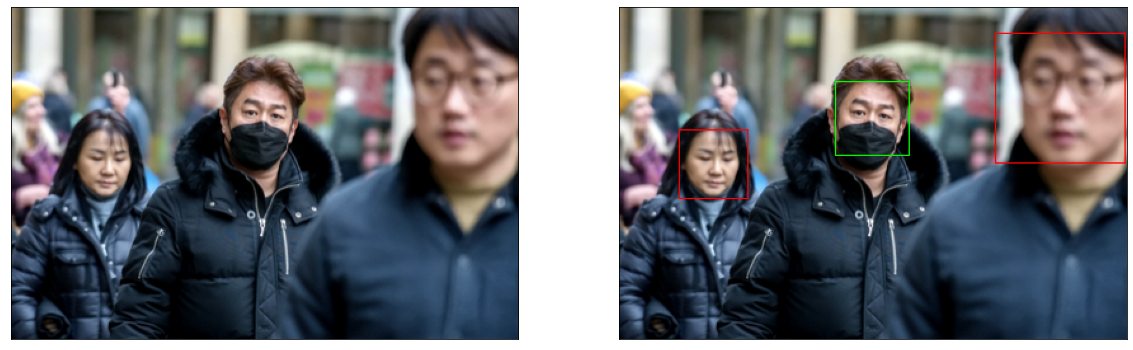

In [58]:
# try it on the sample image
detect_mask("/content/BIOSTAT823-Project/00_Data/Predict Sample/maksssksksss244.png")